Loaded 1500 images for training.
Epoch 1/10
85/85 - 9s - 110ms/step - loss: 57.9974 - val_loss: 0.6921
Epoch 2/10
85/85 - 8s - 97ms/step - loss: 0.6815 - val_loss: 0.6738
Epoch 3/10
85/85 - 8s - 90ms/step - loss: 0.6860 - val_loss: 0.6742
Epoch 4/10
85/85 - 8s - 93ms/step - loss: 0.6751 - val_loss: 0.6739
Epoch 5/10
85/85 - 8s - 93ms/step - loss: 0.6751 - val_loss: 0.6721
Epoch 6/10
85/85 - 8s - 94ms/step - loss: 3.2062 - val_loss: 3.1945
Epoch 7/10
85/85 - 8s - 92ms/step - loss: 1.3147 - val_loss: 0.7335
Epoch 8/10
85/85 - 8s - 92ms/step - loss: 0.7035 - val_loss: 0.6883
Epoch 9/10
85/85 - 8s - 91ms/step - loss: 0.6899 - val_loss: 0.6782
Epoch 10/10
85/85 - 8s - 92ms/step - loss: 0.6831 - val_loss: 0.6820
Epoch 1/10
85/85 - 9s - 103ms/step - loss: 7020610560.0000 - val_loss: 112.5287
Epoch 2/10
85/85 - 8s - 93ms/step - loss: 87.0893 - val_loss: 48.8727
Epoch 3/10
85/85 - 8s - 91ms/step - loss: 290.6727 - val_loss: 129.1246
Epoch 4/10
85/85 - 8s - 92ms/step - loss: 124.4110 - val_loss:

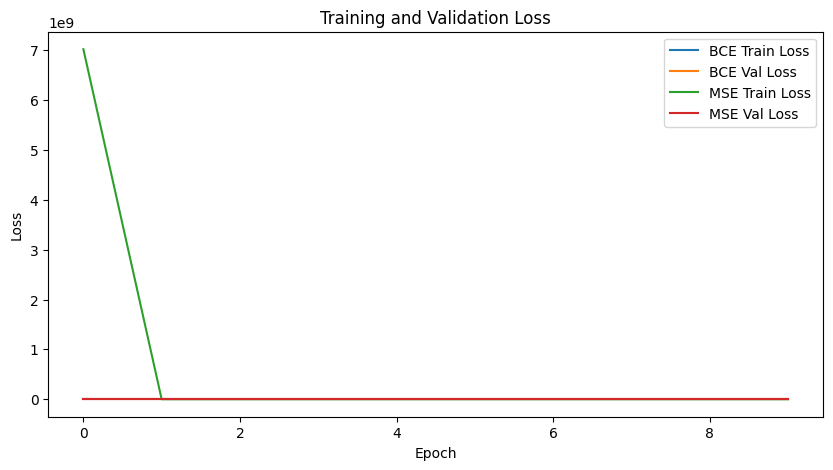

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


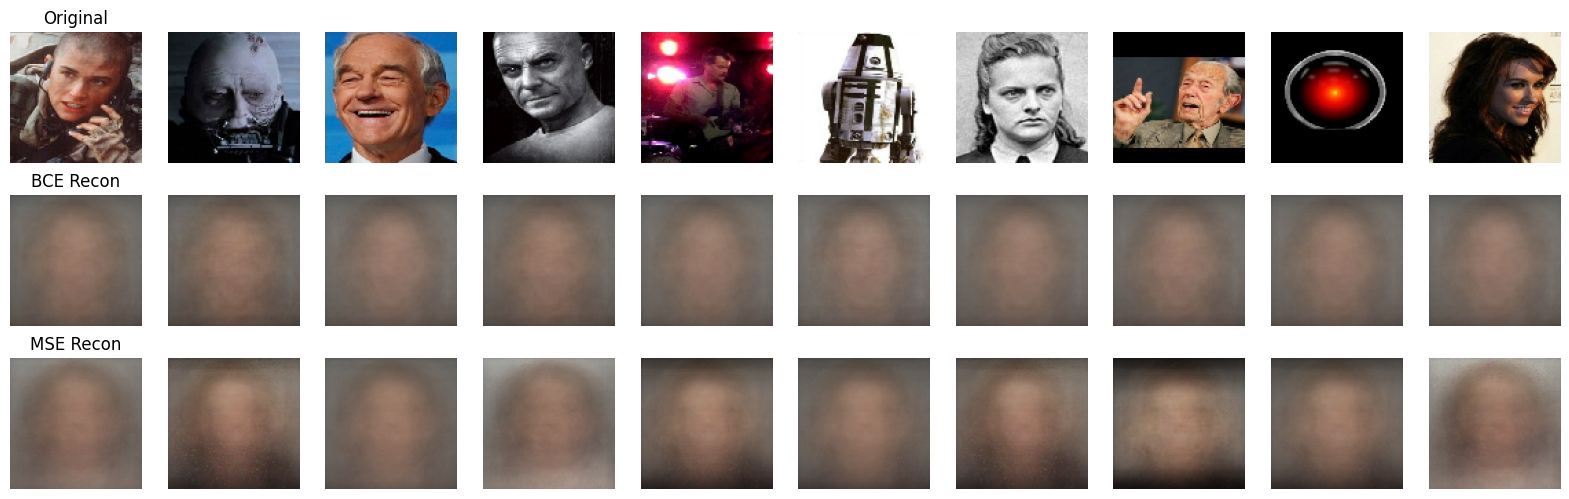

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


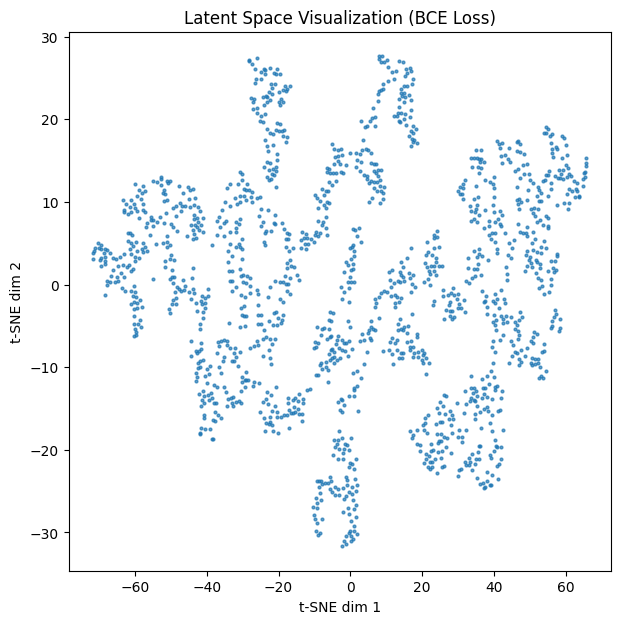

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


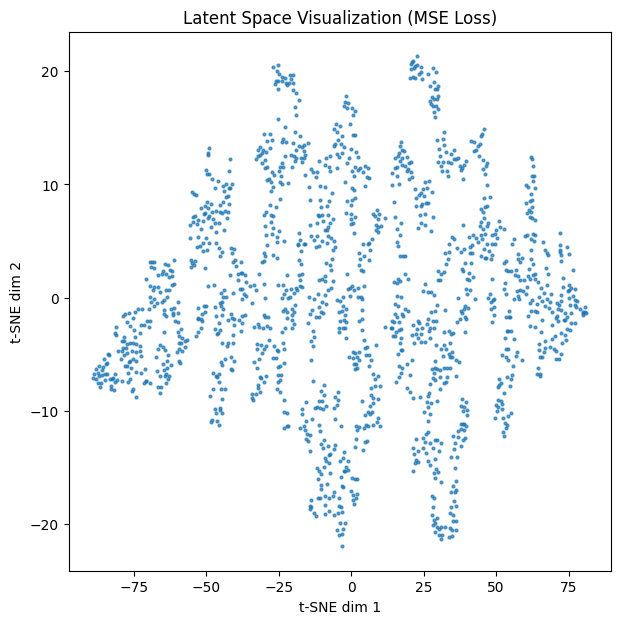

In [17]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Reshape, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from pathlib import Path
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Parameters
LATENT_DIM = 2
BATCH_SIZE = 16
EPOCHS = 10
DATASET_SIZE_LIMIT = 1500
IMG_SIZE = (96, 96)  # your image size

# Custom KL Divergence layer (adds loss internally)
class KLDivergenceLayer(Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        self.add_loss(K.mean(kl_loss))
        return inputs

def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

def create_vae(input_shape, latent_dim):
    inputs = Input(shape=input_shape)
    x = Flatten()(inputs)
    x = Dense(256, activation='relu')(x)
    z_mean = Dense(latent_dim)(x)
    z_log_var = Dense(latent_dim)(x)

    # Add KL divergence loss
    z_mean, z_log_var = KLDivergenceLayer()([z_mean, z_log_var])

    z = Lambda(sampling)([z_mean, z_log_var])

    decoder_hidden = Dense(256, activation='relu')
    decoder_output = Dense(int(np.prod(input_shape)), activation='sigmoid')
    x_decoded = decoder_hidden(z)
    x_decoded = decoder_output(x_decoded)
    outputs = Reshape(input_shape)(x_decoded)

    vae = Model(inputs, outputs)
    return vae, Model(inputs, z_mean)  # Also return encoder model for latent visualization

def load_images_from_path(path, img_size=IMG_SIZE):
    images = []
    if not path.exists():
        print(f"Error: Directory not found at {path}")
        return np.array(images)
    files = sorted(list(path.glob('*')))
    for f in files:
        img = load_img(f, target_size=img_size)
        img = img_to_array(img) / 255.0
        images.append(img)
    return np.array(images)

def prepare_datasets():
    left_imgs = load_images_from_path(Path("Data/left"))
    right_imgs = load_images_from_path(Path("Data/right"))
    if len(left_imgs) == 0 or len(right_imgs) == 0:
        raise RuntimeError("No images loaded. Check 'Data/left' and 'Data/right'.")
    limit = min(DATASET_SIZE_LIMIT, len(left_imgs), len(right_imgs))
    # For simplicity, let's just take left images for VAE training (can be adapted)
    return left_imgs[-limit:]

def train_vae(images, loss_type='bce'):
    input_shape = images.shape[1:]
    vae, encoder = create_vae(input_shape, LATENT_DIM)

    if loss_type == 'bce':
        reconstruction_loss_fn = tf.keras.losses.binary_crossentropy
    elif loss_type == 'mse':
        reconstruction_loss_fn = tf.keras.losses.mse
    else:
        raise ValueError("loss_type must be 'bce' or 'mse'")

    def vae_loss(y_true, y_pred):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        return K.mean(reconstruction_loss_fn(y_true_f, y_pred_f))

    vae.compile(optimizer='adam', loss=vae_loss)

    history = vae.fit(images, images,
                      epochs=EPOCHS,
                      batch_size=BATCH_SIZE,
                      validation_split=0.1,
                      verbose=2)
    return vae, encoder, history

def plot_loss(history_bce, history_mse):
    plt.figure(figsize=(10,5))
    plt.plot(history_bce.history['loss'], label='BCE Train Loss')
    plt.plot(history_bce.history['val_loss'], label='BCE Val Loss')
    plt.plot(history_mse.history['loss'], label='MSE Train Loss')
    plt.plot(history_mse.history['val_loss'], label='MSE Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_reconstructions(vae_bce, vae_mse, images):
    decoded_bce = vae_bce.predict(images[:10])
    decoded_mse = vae_mse.predict(images[:10])

    plt.figure(figsize=(20,6))
    for i in range(10):
        # Original
        ax = plt.subplot(3, 10, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.axis('off')
        if i == 0:
            ax.set_title("Original")

        # BCE Reconstruction
        ax = plt.subplot(3, 10, i + 1 + 10)
        plt.imshow(decoded_bce[i].squeeze(), cmap='gray')
        plt.axis('off')
        if i == 0:
            ax.set_title("BCE Recon")

        # MSE Reconstruction
        ax = plt.subplot(3, 10, i + 1 + 20)
        plt.imshow(decoded_mse[i].squeeze(), cmap='gray')
        plt.axis('off')
        if i == 0:
            ax.set_title("MSE Recon")

    plt.show()

def plot_latent_space(encoder, images, title):
    z_mean = encoder.predict(images)
    # Use t-SNE for 2D visualization (latent dim = 2 so this is optional but still useful)
    tsne = TSNE(n_components=2, random_state=42)
    z_tsne = tsne.fit_transform(z_mean)
    plt.figure(figsize=(7,7))
    plt.scatter(z_tsne[:, 0], z_tsne[:, 1], s=4, alpha=0.7)
    plt.title(title)
    plt.xlabel('t-SNE dim 1')
    plt.ylabel('t-SNE dim 2')
    plt.show()

def main():
    images = prepare_datasets()
    print(f"Loaded {len(images)} images for training.")

    # Train VAE with BCE loss
    vae_bce, encoder_bce, history_bce = train_vae(images, loss_type='bce')

    # Train VAE with MSE loss
    vae_mse, encoder_mse, history_mse = train_vae(images, loss_type='mse')

    # Plot training loss
    plot_loss(history_bce, history_mse)

    # Plot reconstructions side-by-side
    plot_reconstructions(vae_bce, vae_mse, images)

    # Visualize latent spaces
    plot_latent_space(encoder_bce, images, "Latent Space Visualization (BCE Loss)")
    plot_latent_space(encoder_mse, images, "Latent Space Visualization (MSE Loss)")

if __name__ == "__main__":
    main()
